# Spotify Genre Prediction

### 1. Preprocesamiento y Transformación

- Importar librerías

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

- Importar CSV

In [90]:
df = pd.read_csv('train.csv')

- Eliminar las filas duplicadas

In [91]:
df_cleaned = df.drop_duplicates(subset='id', keep='last')

- Eliminar columnas irrelevantes:
  - *Categóricas*: IDs, ruidos y etiquetas repetidas (sin valor predictivo).
  - *'mode', 'key', 'time_signature'*: Baja importancia en el EDA para identificar géneros.
  - *'loudness'*: Alta correlación con 'energy' (0.598), lo que genera redundancia.

In [92]:
columns_to_drop = ['type', 'id', 'uri', 'track_href', 'analysis_url', 'genre', 'song_name', 'title', 'Unnamed: 0', 'Id', 'mode', 'key', 'time_signature', 'loudness']

df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

- Normalizar datos

In [93]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

- Guardar dataset limpio

In [94]:
df_scaled.to_csv("train_clean.csv", index=False)
df_scaled.head()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,1.640192,-0.392062,1.839910,-0.491316,-0.767334,-0.715319,1.317208,1.781719,-0.957013
1,-1.328201,1.085896,-0.051699,-0.549142,-0.331527,2.360748,-0.998500,-0.394293,-0.311599
2,0.296738,-0.386609,1.475835,2.263485,-0.767334,-0.257060,1.248721,1.106304,0.174947
3,-1.270624,0.698682,-0.787765,-0.456749,1.425152,-0.171882,-1.378173,1.157778,0.663642
4,-1.686455,0.616876,-0.281225,-0.358321,-0.767334,-0.506916,-0.459167,2.293609,-0.279109


### 2. Diseño, Entrenamiento y Evaluación del Modelo

In [95]:
df_scaled = pd.read_csv("train_clean.csv")

#### Aplicar PCA

- Determina el número optimo de componentes

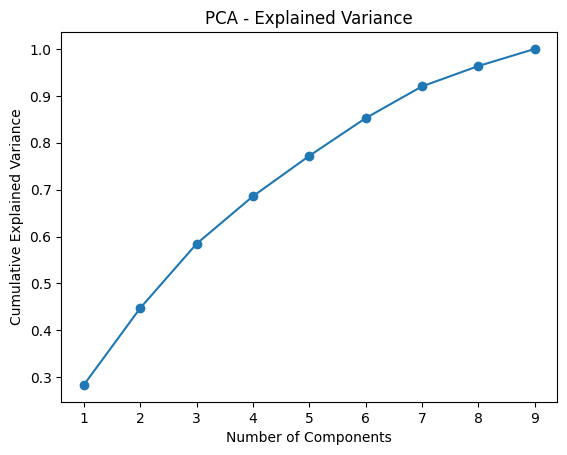

In [96]:
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# Determine optimal number of components
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance")
plt.show()

- Reducimos dimensiones usando 8 componentes el numero de coponentes que explica el 95% del conjunto

In [97]:
pca_opt = PCA(n_components=8)
df_pca_opt = pca_opt.fit_transform(df_scaled)

####  Aplicar K-Means

- Usamos la mejor K a través del método del codo

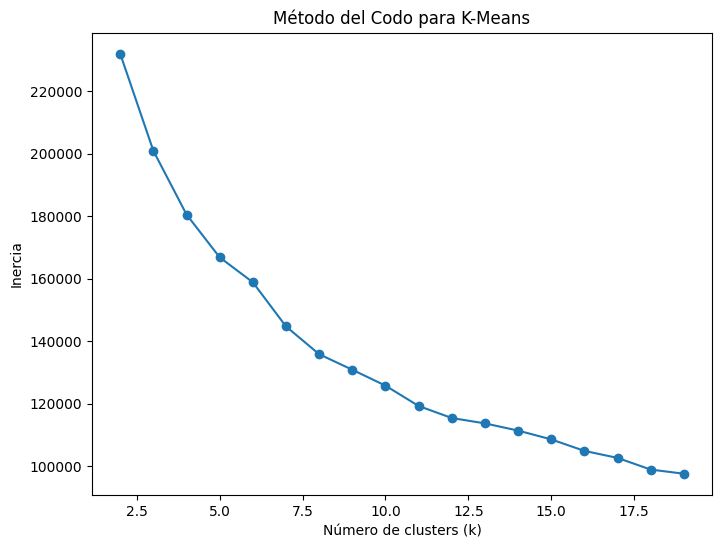

In [98]:
best_k, best_inertia = 2, float('inf')
inertia_values = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca_opt)
    inertia_values.append(kmeans.inertia_)  # Guardar la inercia para cada valor de k

# Graficar la inercia en función de k
plt.figure(figsize=(8, 6))
plt.plot(range(2, 20), inertia_values, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.show()

- Aplicar K-Means con el mejor K

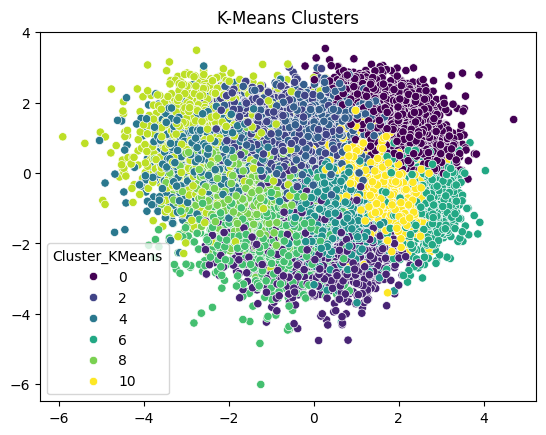

In [99]:
kmeans = KMeans(n_clusters=11, random_state=42)
df_scaled['Cluster_KMeans'] = kmeans.fit_predict(df_pca_opt)

sns.scatterplot(x=df_pca_opt[:, 0], y=df_pca_opt[:, 1], hue=df_scaled['Cluster_KMeans'], palette="viridis")
plt.title("K-Means Clusters")
plt.show()

#### Aplicar DBSCAN

- Optimizar DBSCAN con Grid Search para mejores hiperparámetros

In [100]:
param_grid = {'eps': np.arange(1.0, 3.0, 0.2), 'min_samples': range(5, 20, 5)}
best_eps, best_min_samples, best_silhouette = None, None, -1

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(df_pca_opt)
    if len(set(labels)) > 1:  # Avoid single-cluster cases
        score = silhouette_score(df_pca_opt, labels)
        if score > best_silhouette:
            best_eps, best_min_samples, best_silhouette = params['eps'], params['min_samples'], score

print(f"Best DBSCAN: eps={best_eps}, min_samples={best_min_samples} with silhouette score {best_silhouette}")

Best DBSCAN: eps=2.3999999999999995, min_samples=5 with silhouette score 0.4444222478020066


- Entrena DBSCAN con los mejores hiperparámetros

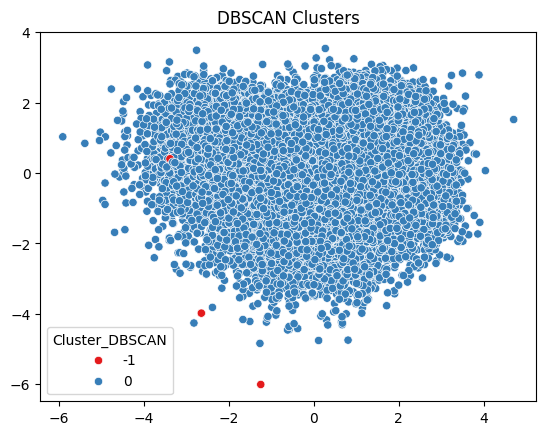

In [101]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df_scaled['Cluster_DBSCAN'] = dbscan.fit_predict(df_pca_opt)

sns.scatterplot(x=df_pca_opt[:, 0], y=df_pca_opt[:, 1], hue=df_scaled['Cluster_DBSCAN'], palette="Set1")
plt.title("DBSCAN Clusters")
plt.show()

#### Evaluar modelos

- Evaluación KMeans

In [102]:
silhouette_kmeans = silhouette_score(df_pca_opt, df_scaled['Cluster_KMeans'])
davies_kmeans = davies_bouldin_score(df_pca_opt, df_scaled['Cluster_KMeans'])
calinski_kmeans = calinski_harabasz_score(df_pca_opt, df_scaled['Cluster_KMeans'])

print(f"K-Means: Silhouette {silhouette_kmeans}, Davies-Bouldin {davies_kmeans}, Calinski-Harabasz {calinski_kmeans}")

K-Means: Silhouette 0.18324941775332312, Davies-Bouldin 1.5063326580229797, Calinski-Harabasz 4939.977806748899


- Evaluación DBSCAN

In [103]:
silhouette_dbscan = silhouette_score(df_pca_opt, df_scaled['Cluster_DBSCAN'])
davies_dbscan = davies_bouldin_score(df_pca_opt, df_scaled['Cluster_DBSCAN'])
calinski_dbscan = calinski_harabasz_score(df_pca_opt, df_scaled['Cluster_DBSCAN'])

print(f"DBSCAN: Silhouette {silhouette_dbscan}, Davies-Bouldin {davies_dbscan}, Calinski-Harabasz {calinski_dbscan}")

DBSCAN: Silhouette 0.4444222478020066, Davies-Bouldin 1.624608057386435, Calinski-Harabasz 30.10914024235139


### 3. Resultados y conclusiones